In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.initializers import glorot_uniform
import datetime
from keras.applications.resnet import preprocess_input as preprocess_input_ResNet
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename, verbose=False, verify=True): 
    if verbose:
        print(f'Load file {filename} ...')
    
    ds = pydicom.dcmread(filename)
    desc, mod, part, sex, age, pos = [ds.StudyDescription, ds.Modality, ds.BodyPartExamined,
                                     ds.PatientSex, ds.PatientAge, ds.PatientPosition]
    if verify:
        if (mod != 'DX'):
            print(f"Loaded DICOM '{filename}' with incorrect modality: {mod}, must be DX")
            return None
        if (pos not in ['AP', 'PA']):
            print(f"Loaded DICOM '{filename}' with incorrect patient position: {pos}, must be AP or PA")
            return None
        if (part != 'CHEST'):
            print(f"Loaded DICOM '{filename}' with incorrect body part examined: {part}, must be CHEST")
            return None
        
    if verbose:    
        print("DICOM Metadata: ")
        print(f"  Study Description: {desc}")
        print(f"  Modality: {mod}")
        print(f"  Body Part Examined: {part}")
        print(f"  Patient sex: {sex}")
        print(f"  Patient age: {age}")
        print(f"  Patient position: {pos}")
    
    img = ds.pixel_array
    return img
    
# This function takes the numpy array output by check_dicom and runs the appropriate pre-processing needed for model input
def preprocess_image(img, plot=False): 
    # Resize
    IMG_SIZE = (224, 224)
    resized_img = np.expand_dims(img, axis=2)
    resized_img = tf.image.grayscale_to_rgb(tf.convert_to_tensor(resized_img)).numpy()
    resized_img = np.array(Image.fromarray(resized_img).resize((IMG_SIZE))) # Use PIL to avoid scaling to 0-1 range
    
    # Apply ResNet Preprocessing
    # NOTE: ResNet image preprocessing in TF.Keras uses "caffe" pre-processing style, which is recentered but not normalized
    proc_img = np.expand_dims(resized_img, axis=0)
    proc_img = preprocess_input_ResNet(proc_img)

    if(plot):
        plt.figure(figsize=(14,12));
        plt.subplot(2,2,1);
        plt.imshow(img);
        plt.title("Input Image");
        
        plt.subplot(2,2,2);
        plt.hist(img.ravel(), bins=256);
        plt.title("Intensities Before Preprocessing");
        
        plt.subplot(2,2,3);
        plt.imshow(proc_img[0,:,:,0]);
        plt.title('Preprocessed Image for Inference');

        plt.subplot(2,2,4);
        plt.hist(proc_img[0].ravel(), bins=256);
        plt.title("Intensities After Preprocessing");
        plt.show();
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    print(f"Loading model at path '{model_path}' with weights at path '{weight_path}'")
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    
    optimizer = 'adam' # Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh, verbose=False):
    y = model.predict(img)[0][0]
    if (y > thresh):
        if verbose:
            print(f"Model output {y} exceeds threshold {thresh}: Pneumonia Detected")
        return True
    if verbose:
        print(f"Model output {y} is below threshold {thresh}: Pneumonia Not Detected")
    return False

Loaded DICOM 'test4.dcm' with incorrect body part examined: RIBCAGE, must be CHEST
Loaded DICOM 'test5.dcm' with incorrect modality: CT, must be DX
Loaded DICOM 'test6.dcm' with incorrect patient position: XX, must be AP or PA


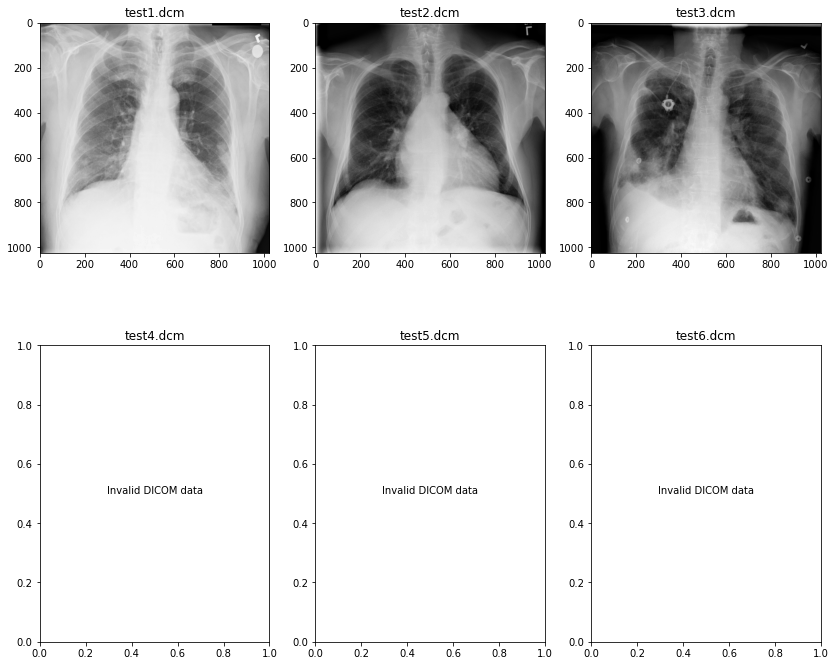

In [3]:
# Test check_dicom()
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

plt.figure(figsize=(14,12)) 
for i in range(1, 7):
    dcm_name = test_dicoms[i-1]
    plt.subplot(2,3,i);
    img = check_dicom(dcm_name)
    if img is not None:
        plt.imshow(img, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'Invalid DICOM data', horizontalalignment='center')
    plt.title(dcm_name)
plt.show()

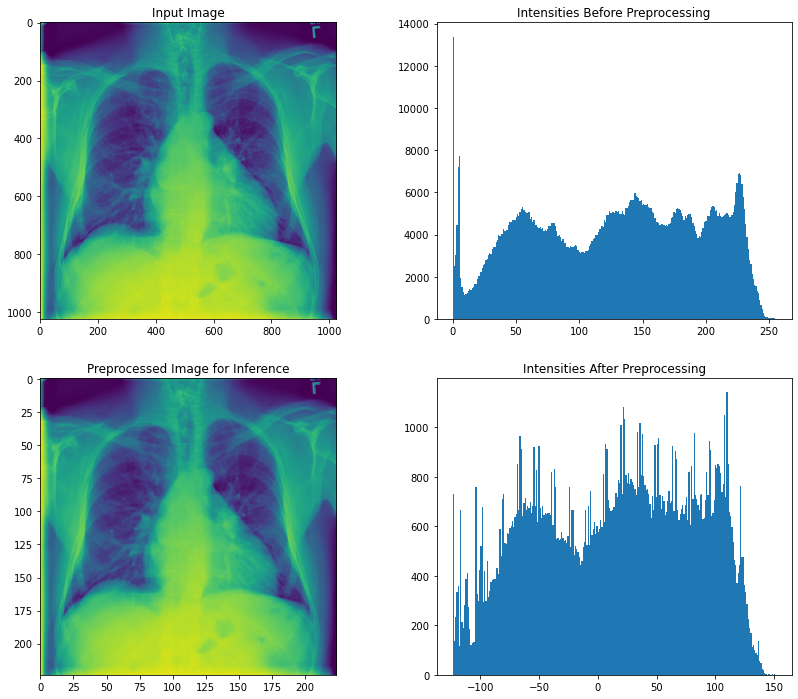

preprocess_image() returns batch with shape: (1, 224, 224, 3)


In [11]:
# Check preprocess_image()
processed = preprocess_image(check_dicom('test2.dcm'), plot=True)
print(f"preprocess_image() returns batch with shape: {processed.shape}")

In [12]:
# Check load_model()
model = load_model("my_model.json", "xray_class_my_model.best.hdf5")

Loading model at path 'my_model.json' with weights at path 'xray_class_my_model.best.hdf5'


In [13]:
# Check predict_image()
img_proc = preprocess_image(check_dicom('test2.dcm'), plot=False)
thresh = 0.1 # Sample threshold; not final algorithm threshold
pred = predict_image(model, img_proc, thresh, verbose=True)
print(pred)

Model output 4.40451804024633e-05 is below threshold 0.1: Pneumonia Not Detected
False


In [14]:
model_path = "my_model.json"
weight_path = "xray_class_my_model.best.hdf5"

my_model = load_model(model_path, weight_path)

Loading model at path 'my_model.json' with weights at path 'xray_class_my_model.best.hdf5'


We choose a classification threshold of 0.4 based on the analysis from the 'Optimize Model Performance' section of 'Train_Model' notebook.

Model output 0.0004292387457098812 is below threshold 0.41: Pneumonia Not Detected


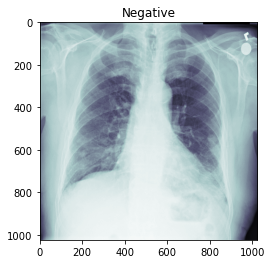

Model output 4.40451804024633e-05 is below threshold 0.41: Pneumonia Not Detected


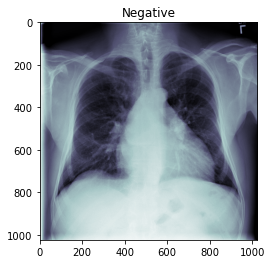

Model output 0.00241589336656034 is below threshold 0.41: Pneumonia Not Detected


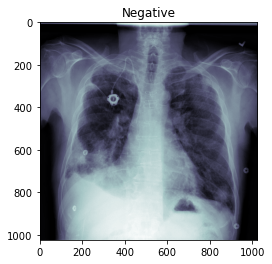

Loaded DICOM 'test4.dcm' with incorrect body part examined: RIBCAGE, must be CHEST
Loaded DICOM 'test5.dcm' with incorrect modality: CT, must be DX
Loaded DICOM 'test6.dcm' with incorrect patient position: XX, must be AP or PA


In [15]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']
thresh = 0.41

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img)
    pred = predict_image(my_model,img_proc,thresh, verbose=True)
    
    plt.imshow(img, cmap='bone')
    plt.title("Positive" if pred else "Negative")
    plt.show()
